In [143]:
from sklearn import datasets, cross_validation, tree, metrics, linear_model
import xgboost as xgb
import pandas as pd
import numpy as np

In [74]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [84]:
def write_answer(num, answer):
    with open("week4_boosting_answer{}.txt".format(num), "w") as fout:
        fout.write(str(answer))

In [75]:
boston = datasets.load_boston()

In [76]:
X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target).rename(columns={0 : 'target'})

In [77]:

pd.concat([X, y], axis=1).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [78]:
trainsize = int(0.75 * boston.data.shape[0])
X_train = boston.data[:trainsize]  
y_train = boston.target[:trainsize]
X_test = boston.data[trainsize:]
y_test = boston.target[trainsize:]

# TASK 1

Как вы уже знаете из лекций, бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

# TASK 2

Заведите массив для объектов DecisionTreeRegressor (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

In [79]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(algos, coeffs)]) for x in X]

In [81]:
algos = []
coeffs = []
shifts = y_train
for i in range(0, 50):
    regressor = tree.DecisionTreeRegressor(random_state=42, max_depth=5)
    regressor.fit(X_train, shifts)
    algos.append(regressor)
    coeffs.append(0.9)
    predictions = gbm_predict(X_train)
    shifts = y_train - predictions

Функция gbm_predict поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE. Полученное значение RMSE — ответ в пункте 2.

In [85]:
answer = metrics.mean_squared_error(y_test, gbm_predict(X_test)) ** 0.5
write_answer(2, answer)
print("RMSE : {}".format(answer))

RMSE : 5.476650974168954


# TASK 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как ответ в пункте 3. В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [135]:
def gradient_boosting(num_round=50, max_depth=5):
    shifts = y_train
    for i in range(0, num_round):
        regressor = tree.DecisionTreeRegressor(random_state=42, max_depth=max_depth)
        regressor.fit(X_train, shifts)
        algos.append(regressor)
        coeffs.append(0.9 / (1.0 + i))
        predictions = gbm_predict(X_train)
        shifts = y_train - predictions

In [97]:
algos = []
coeffs = []
gradient_boosting()

In [96]:
answer = metrics.mean_squared_error(y_test, gbm_predict(X_test)) ** 0.5
write_answer(3, answer)
print("RMSE : {}".format(answer))

RMSE : 4.810893280258557


# TASK 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет ответ в п.4):

1) С увеличением числа деревьев начиная с некоторого момента качество работы градиентного бустинга не меняется существенно.

2) С увеличением числа деревьев начиная с некоторого момента градиентный бустинг начинает переобучаться.

3) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться

4) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

## Gradient boosting with different num_rounds

In [137]:
answers = []
num_rounds = range(1, 50, 5)
for num_round in num_rounds:
    coeffs = []
    algos = []
    gradient_boosting(num_round=num_round)
    answers.append(metrics.mean_squared_error(y_test, gbm_predict(X_test)) ** 0.5)   

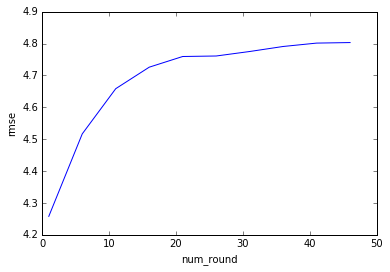

In [138]:
plt.plot(num_rounds, answers)
plt.xlabel('num_round')
plt.ylabel('rmse')
plt.show()

## Gradient boosting with different max_depth

In [141]:
answers = []
max_depths = range(1, 20, 2)
for max_depth in max_depths:
    coeffs = []
    algos = []
    gradient_boosting(max_depth=max_depth)
    answers.append(metrics.mean_squared_error(y_test, gbm_predict(X_test)) ** 0.5)

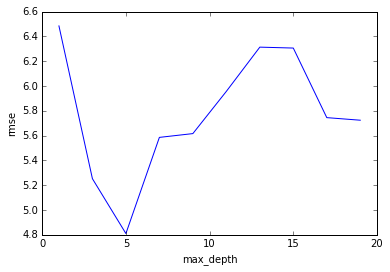

[6.4852743644178457, 5.2531342152395686, 4.8108932802585569, 5.5863425268163684, 5.6169080992497626, 5.957457227169801, 6.314176486377848, 6.3067529265662978, 5.7456874410962753, 5.7248480301136837]


In [142]:
plt.plot(max_depths, answers)
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()
print(answers)

In [125]:
answer = '2 3'
write_answer(4, answer)

# TASK 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [145]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [147]:
answer = metrics.mean_squared_error(y_test, regressor.predict(X_test)) ** 0.5
print("RMSE using LinearRegression : {}".format(answer))
write_answer(5, answer)

RMSE using LinearRegression : 8.270468034938437
